# [IT8302] Applied Machine Learning: Stock Price Forecasting

## Table of Contents
1. [Import Libraries](#1)
2. [Exploratory Data Analysis & Preparation](#2)
3. [Apple Analysis](#3)
4. [Amazon Analysis](#4)
5. [DBS Analysis](#5)
6. [Conclusion](#6)

__Introduction__  
Time series modelling is a powerful tool for analysing temporal data and generating future predictions. While forecasts may not always be entirely accurate, they offer valuable insights into potential trends and help anticipate future movements. In this analysis, we apply time series methods such as Holt-Winters Exponential Smoothing (HWES) and Seasonal ARIMA (SARIMA) modelling to predict the stock prices of Apple, Amazon, and DBS over the next 60 days. The dataset used in this study consists of daily stock prices for these three companies, recorded on business days from 2018 to 2023.

__Datasets used__  
Apple, Amazon, and DBS Stock Dataset (provided by Singapore Polytechnic)

# 1. Import Libraries <a id = '1'></a>

In [1]:
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

# 2. Exploratory Data Analysis (EDA) <a id = '2'></a> 

## Data Structure

We begin by loading the stock price dataset and examining the data for the following:
- Column data types;
- Presence of any null values; and
- Descriptive statistics for each column.

In [2]:
# Import stock price datset
stocks_df = pd.read_csv(
    "data/CA2-Stock-Price-Data.csv",
    parse_dates=["Date"],
    infer_datetime_format=True,
    index_col="Date",
)

# Get info on dataset, check if any nulls and data types
stocks_df.info()

# Descriptive statistics of each column (to see range of values for date and stock prices)
stocks_df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-01 to 2023-09-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


,Apple,Amazon,DBS
count,1257.000000,1257.000000,1257.000000
mean,116.168385,124.791237,28.185863
std,46.945568,32.495925,4.738732
min,35.547501,67.197998,16.879999
25%,66.592499,93.489998,24.879999
50%,129.610001,120.970001,28.650000
75%,152.589996,158.100494,32.480000
max,196.449997,186.570496,37.250000


In [3]:
# Inspect dataframe
stocks_df.head(10)

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
2018-10-08,55.942501,93.221001,25.469999
2018-10-09,56.717499,93.515999,25.260000
2018-10-10,54.090000,87.762497,24.950001
2018-10-11,53.612499,85.968002,24.309999


The dataset appears to record stock prices based on business days. Therefore, we resample the data using a daily (“D”) offset and compute the mean if multiple values exist for a given day.

To handle any missing values, we apply the forward fill method, using the last available closing price to fill gaps, such as those occurring over weekends.

In [4]:
# Resample to get business day frequency (as suggested by dataset index)
stocks_df = stocks_df.resample("D")[["Apple", "Amazon", "DBS"]].mean()

# Impute mean with previous closing day's price
stocks_df.fillna(method="ffill", inplace=True)

To provide a clearer visual representation of the dataset, we plot the 5-day Simple Moving Average (SMA) for each stock.

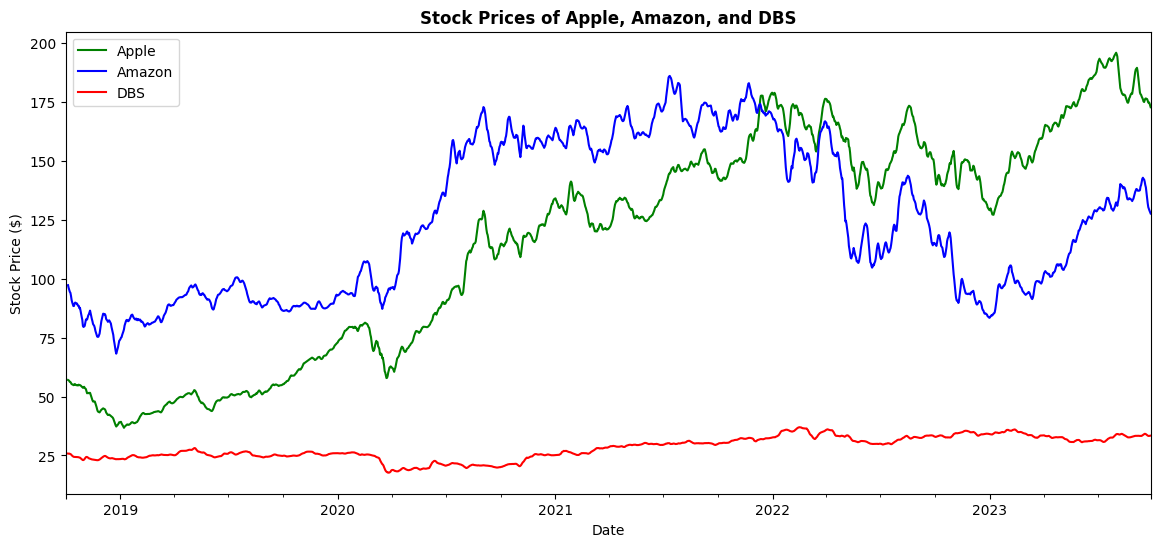

In [5]:
# Create list of time series data
ts_list = [stocks_df["Apple"], stocks_df["Amazon"], stocks_df["DBS"]]
ts_colours = ["g", "b", "r"]

# Plot SMA(5) of stock prices for Apple, Amazon, and DBS
plt.figure(figsize=(14, 6))

for i in range(len(ts_list)):
    ts_list[i].rolling(window=5).mean().plot(c=ts_colours[i])

plt.title("Stock Prices of Apple, Amazon, and DBS", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend(["Apple", "Amazon", "DBS"])

plt.show()

## Time Series Stationarity & Seasonality

At this stage, we define functions to facilitate our analysis, focusing on the following:

1. __Computing the log-transformed stock prices__. Taking the log of prices in time series analysis serves several key purposes:
    - __Stabilising variance (homoscedasticity)__.
        Many financial time series exhibit heteroscedasticity, where volatility changes over time.
	    Applying a log transformation reduces the impact of large fluctuations, making the variance more stable and improving model performance.
	- __Converting multiplicative relationships to additive ones__.
        Many time series models (e.g., SARIMA) assume additive relationships between variables.
        Stock prices often follow a multiplicative pattern (e.g., percentage-based changes), so taking logs makes the data more suitable for linear models.
	- __Making returns more interpretable__.
	    Instead of analysing absolute price differences, we focus on log returns: $\log(P_t) - \log(P_{t-1}) = \log\left(\frac{P_t}{P_{t-1}}\right)$. This represents percentage changes in a more mathematically convenient way, making returns comparable over time.
    - __Improving stationarity__.
        Many financial time series exhibit non-stationarity due to long-term trends.
        Taking the log helps dampen exponential growth and makes it easier to achieve stationarity, reducing the need for excessive differencing.        

2. __Assessing stationarity using the Augmented Dickey-Fuller (ADF) test__. This is crucial for the following reasons:
    - __Stationarity ensures reliable forecasting__.
        Stationarity of time series is a key assumption of many time series model such as SARIMA. If a time series is non-stationary, predictions may be inaccurate or misleading.
    - __Identifying the need for differencing__.
        The ADF test determines whether differencing is required to make the time series stationary. This will determine the number of differences, $d$ and $D$, in SARIMA (p, __d__, q) and (P, __D__, Q, S).
    - __Ensuring proper interpretation of ACF and PACF__.
        The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) behave predictably only when the series is stationary. If the series is non-stationary, the ACF may not decay properly, making model selection harder.

3. __Visualising seasonal decomposition of the dataset__. This helps us with:
    - __Identifying key components of the time series__, such as: Trend (long-term increase/decrease), Seasonality (patterns that repeat at regular intervals), and Residuals (random noise).
        Decomposing the time series down will allow to analyse these components separately and determine their impact on the data
    - __Selecting the right model__. If seasonality exists, a seasonal model like SARIMA or Holt-Winters is required.
        By decomposing the time series, we can determine whether seasonal adjustment is necessary before modelling.
    - __Facilitating data transformation__. If seasonality dominates, applying seasonal differencing may be necessary. Decomposition provides insight into the best pre-processing steps for the dataset.

4. __Generating Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots__. This is necessary to:
    - __Identify the Autoregressive (AR) and Moving Average (MA) components in our time series models__.
        The ACF plot illustrates the correlation between the time series and its lags (i.e., past values), which helps in identifying the MA component (denoted by $q$ in SARIMA) by detecting spikes at specific lags.
        In contrast, the PACF plot measures the correlation between the time series and its lags, while eliminating the effect of intermediate lags. This enables a clearer understanding of the relationship between the series and a particular lag, which helps in identifying the AR component (denoted by $p$ in ARIMA) by observing spikes at specific lags.
    - __Detecting seasonal AR and MA components.__.
        By analysing both ACF and PACF plots, we can identify the seasonal AR ($P$) and MA ($Q$) components in SARIMA models, as spikes at regular intervals in the plots correspond to the seasonal periodicity ($S$) of the data.

In [6]:
def calculate_log_price(ts: pd.Series) -> pd.Series:
    """Calculate the log price of a stock over time.

    Args:
        ts (pd.Series): Time series data to calculate log price

    Returns:
        pd.Series: Time series of log price
    """

    log_price = np.log(ts)

    return log_price

In [7]:
def adf_test(
    ts: pd.Series,
    name: str,
    k_diff: int = 0,
    k_seasonal_diff: int = None,
    seasonal_periods: int = 1,
) -> None:
    """Tests time series for stationarity using Augmented Dickey-Fuller test.

    Args:
        ts (pd.Series): Time series data to be tested for stationarity
        name (str): Name for logging the test
        k_diff (int): Number of differences
        k_seasonal_diff (int): Number of seasonal differences
        seasonal_periods (int): Period fo seasonal differencing
    """
    logger.debug(f"Performing ADF Test for {name}")
    ts = diff(
        ts,
        k_diff=k_diff,
        k_seasonal_diff=k_seasonal_diff,
        seasonal_periods=seasonal_periods,
    )
    adf_test = adfuller(ts)

    adf_statistic = adf_test[0]
    adf_pvalue = adf_test[1]

    logger.info(f"""
    ADF Statistic: {adf_statistic:.5f}
    p-value: {adf_pvalue:.5f}""")

    if adf_pvalue < 0.05:
        logger.success("Time series is stationary\n")
    else:
        logger.warning("Time series is not stationary!\n")

In [8]:
def plot_acf_pacf(ts: pd.Series, acf_lags: int, pacf_lags: int) -> None:
    """Plot pre-formatted ACF and PACF plots for analysis.

    Args:
        ts (pd.Series): Time series data
        acf_lags (int): ACF plot lags
        pacf_lags (int): PACF plot lags
    """
    fig, axes = plt.subplots(3, 1, figsize=(20, 12))
    logger.debug(f"Plotting ACF and PACF plots for {ts.name} Log Returns")

    ts.plot(ax=axes[0])
    axes[0].set_title(f"{ts.name} Stock Log Returns Time Series", fontweight="bold")

    # Plot autocorrelation function
    acf_fig = plot_acf(ts, lags=acf_lags, ax=axes[1])
    axes[1].set_title(
        f"{ts.name} Autocorrelation Function Plot (ACF)", fontweight="bold"
    )
    axes[1].set_xlabel("Lag")

    # Plot partial autocorrelation function
    pacf_fig = plot_pacf(ts, lags=pacf_lags, ax=axes[2])
    axes[2].set_title(
        f"{ts.name} Partial Autocorrelation Function Plot (PACF)", fontweight="bold"
    )
    axes[2].set_xlabel("Lag")

    plt.subplots_adjust(hspace=0.45)
    plt.show()

In [9]:
def plot_seasonal_decomposition(
    ts: pd.Series, decomp_model: str, decomp_period: int
) -> None:
    """Plot pre-formatted seasonal decomposition plots for analysis.

    Args:
        ts (pd.Series): Time series data
        decomp_model (str): Type of decomposition model
        decomp_period (int): Periods for seasonality analysis
    """
    fig, axes = plt.subplots(3, 1, figsize=(20, 12))
    logger.debug(f"Plotting Seasonal Decomposition plots for {ts.name} Log Returns")

    # Plot seasonal decomposition components
    decomposed_ts = seasonal_decompose(ts, model=decomp_model, period=decomp_period)

    decomposed_ts.trend.plot(ax=axes[0])
    axes[0].set_title(f"{ts.name} Trend", fontweight="bold")

    decomposed_ts.seasonal.plot(ax=axes[1])
    axes[1].set_title(f"{ts.name} Seasonality", fontweight="bold")

    decomposed_ts.resid.plot(ax=axes[2])
    axes[2].set_title(f"{ts.name} Residuals", fontweight="bold")

    plt.subplots_adjust(hspace=0.3)
    plt.show()

## Model Analysis

In addition to functions that aid in analysing the time series data, we also prepare specific functions to assist with the modelling process. These include:

1. __Train-test split of the dataset (80-20%)__. This helps divide the data into training and testing sets, ensuring that the model is trained on a sufficient amount of data while leaving a portion for evaluation. This split is essential for assessing the model’s performance and identifying the best hyperparameters for improved accuracy and generalisation.

2. __Training and evaluation of our time series models (Holt-Winters and SARIMA)__. A structured pipeline is developed to handle training, fitting, predicting, plotting, and evaluating results according to the requirements of each model. This approach ensures consistency and reusability across the three stocks under analysis.
    Our models are developed iteratively, with hyperparameters determined from the time series analysis using the above functions. These parameters are then fine-tuned to ensure that both AICc (Corrected Akaike Information Criterion) and MAPE (Mean Absolute Percentage Error) are minimised.
    These two metrics were chosen for evaluation because:
	- __AICc__ is a modification of the AIC that adjusts for small sample sizes, making it more reliable when data points are limited. It helps strike a balance between the goodness of fit and model complexity by penalising overfitting. This is especially important in time series analysis, where models often have many parameters. A lower AICc indicates a better-fitting model that captures the underlying patterns in the data without overfitting.
	- __MAPE__ is widely used in forecasting due to its intuitive, scale-independent measure of forecast accuracy. By calculating the percentage error between predicted and actual values, MAPE enables the assessment of how far off the model’s predictions are from the actual outcomes. This makes it particularly useful for evaluating models like SARIMA and Holt-Winters, where accurate future stock price predictions are the goal. It also facilitates easy comparison between different models or datasets, as it standardises the errors as a percentage of the actual values.


3. __Training and forecasting the stock price for the next 60 days__. Similarly, we develop a pipeline to train, fit, predict, plot, and evaluate the results for forecasting stock prices. This maintains consistency and reusability across all three stocks for a 60-day forecast horizon.

In [10]:
def train_test_split(ts: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """Splits time series data into training and testing set for modelling.

    Args:
        ts (pd.Series): Time series data

    Returns:
        Tuple[pd.Series, pd.Series]: Outputs train and test datasets respectively
    """
    index_split = np.percentile(ts.index, 80)
    train, test = (
        ts[ts.index < index_split],
        ts[ts.index >= index_split],
    )

    return train, test

In [11]:
def train_eval_arima_model(
    train: pd.Series,
    test: pd.Series,
    order: tuple,
    seasonal_order: tuple = (0, 0, 0, 0),
) -> None:
    """Train and evaluate a SARIMA model with the defined order and seasonal order. Generates plots, model AICc, and prediction MAPE.

    Args:
        train (pd.Series): Training dataset
        test (pd.Series): Test dataset
        order (tuple): (p,d,q) order of the model for the autoregressive, differences, and moving average components.
        seasonal_order (tuple): (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. Default is (0, 0, 0, 0).
    """
    logger.debug(f"Training and evaluating SARIMA model for {train.name}")

    # Set SARIMA hyperparameters based on diagnostic plots/tests
    p, d, q = order
    P, D, Q, S = seasonal_order

    # Train SARIMA model with best hyperparameters
    arima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit()

    # Print AICc of fitted model for model evaluation
    logger.info(f"SARIMA Model AICc: {arima_model.aicc:.5f}")

    # Out-of-sample predictions
    arima_pred = arima_model.get_prediction(
        start=test.index.min(), end=test.index.max()
    ).predicted_mean

    # Inverse log transform to get original price scale
    forecast_prices = np.exp(arima_pred)
    test_prices = np.exp(test)
    train_prices = np.exp(train)

    # Calculate MAPE for forecasts data
    mape_pred = mean_absolute_percentage_error(test_prices, forecast_prices) * 100
    logger.info(
        f"SARIMA Forecast Mean Absolute Percentage Error (MAPE): {mape_pred:.2f}%"
    )

    # Plot results
    plt.figure(figsize=(14, 6))
    train_prices.plot(c="b", label="Train")
    test_prices.plot(c="g", label="Test")
    plt.axvline(
        x=train.index.max(), color="gray", linestyle="--", label="Forecast Start"
    )
    forecast_prices.plot(c="r", label="SARIMA Model Forecast")

    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.title(f"{train.name} SARIMA Forecast", fontweight="bold")
    plt.show()

In [12]:
def pred_arima_model(
    ts: pd.Series, order: tuple, seasonal_order: tuple = (0, 0, 0, 0)
) -> None:
    """Train a SARIMA model and forecast the next 60 days worth of stock prices.

    Args:
        ts (pd.Series): Time series to fit the model on.
        order (tuple): (p,d,q) order of the model for the autoregressive, differences, and moving average components.
        seasonal_order (tuple): (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. Default is (0, 0, 0, 0).
    """
    logger.debug(
        f"Predicting stock price of {ts.name} for the next 60 days using SARIMA model"
    )

    # Set ARIMA hyperparameters based on diagnostic plots/tests
    p, d, q = order
    P, D, Q, S = seasonal_order

    # Train ARIMA model with best hyperparameters
    arima_model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit()

    # Out-of-sample predictions (60 days)
    arima_pred = arima_model.get_forecast(steps=60).predicted_mean

    # Inverse log transform to get original price scale
    forecast_prices = np.exp(arima_pred)
    original_prices = np.exp(ts)

    # Plot results
    plt.figure(figsize=(14, 6))
    original_prices.plot(c="b", label=f"{ts.name} Stock Price Data")
    plt.axvline(x=ts.index.max(), color="gray", linestyle="--", label="Forecast Start")
    forecast_prices.plot(c="r", label="SARIMA Model 60-Days Forecast")

    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.title(f"{ts.name} SARIMA 60-Days Forecast", fontweight="bold")
    plt.show()

In [13]:
def train_eval_hwes_model(
    train: pd.Series, test: pd.Series, seasonal_periods: int
) -> None:
    """Train and evaluate an Holt-Winters Exponential Smoothing model with the seasonal period. Generates plots, model AICc, and prediction MAPE.

    Args:
        train (pd.Series): Training dataset
        test (pd.Series): Test dataset
        seasonal_periods (int): The number of periods in a complete seasonal cycle
    """
    logger.debug(f"Training and evaluating HWES model for {train.name}")

    hwes_model = HWES(
        train,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="add",
        damped_trend=False,
        # freq="B",
    ).fit()

    # Out-of-sample predictions
    hwes_pred = hwes_model.predict(start=test.index.min(), end=test.index.max())

    # Inverse log transform to get original price scale
    forecast_prices = np.exp(hwes_pred)
    test_prices = np.exp(test)
    train_prices = np.exp(train)

    # Calculate MAPE for forecasts data
    mape_pred = mean_absolute_percentage_error(test_prices, forecast_prices) * 100
    logger.info(
        f"Holt-Winters Exponential Smoothing Forecast Mean Absolute Percentage Error (MAPE): {mape_pred:.2f}%"
    )

    # Plot results
    plt.figure(figsize=(14, 6))
    train_prices.plot(c="b", label="Train")
    test_prices.plot(c="g", label="Test")
    plt.axvline(
        x=train.index.max(), color="gray", linestyle="--", label="Forecast Start"
    )
    forecast_prices.plot(c="r", label="HWES Model Forecast")

    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.title(
        f"{train.name} Holt-Winters Exponential Smoothing Model Forecast",
        fontweight="bold",
    )
    plt.show()

In [14]:
def pred_hwes_model(ts: pd.Series, seasonal_periods: int) -> None:
    """Train a Holt-Winters Exponential Smoothing model and forecast the next 60 days worth of stock prices.

    Args:
        ts (pd.Series): Time series to fit the model on.
        seasonal_periods (int): The number of periods in a complete seasonal cycle
    """
    logger.debug(
        f"Predicting stock price of {ts.name} for the next 60 days using HWES model"
    )

    hwes_model = HWES(
        ts,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="add",
        damped_trend=False,
        # freq="B",
    ).fit()

    # Get start and end date for prediction of stock price for the next 60 days
    start = ts.index.max() + pd.Timedelta(days=1)
    end = ts.index.max() + pd.Timedelta(days=61)

    # Out-of-sample predictions (60 days)
    hwes_pred = hwes_model.predict(start=start, end=end)

    # Inverse log transform to get original price scale
    forecast_prices = np.exp(hwes_pred)
    original_prices = np.exp(ts)

    # Plot results
    plt.figure(figsize=(14, 6))
    original_prices.plot(c="b", label=f"{ts.name} Stock Price Data")
    plt.axvline(x=ts.index.max(), color="gray", linestyle="--", label="Forecast Start")
    forecast_prices.plot(c="r", label="HWES Model 60-Days Forecast")

    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.title(
        f"{ts.name} Holt-Winters Exponential Smoothing Model 60-Days Forecast",
        fontweight="bold",
    )
    plt.show()

In [15]:
# def recursive_forecasting(model: ARIMA, train_data: pd.Series, test_data: pd.Series, order: tuple) -> pd.Series:
#     """Forecasts specified horizon step-wise by feeding the model's on predictions back as inputs for subsequent steps.

#     Args:
#         model (ARIMA): ARIMA time series model
#         train_data (pd.Series): Training data set
#         test_data (pd.Series): Test data set
#         order (tuple): ARIMA model order

#     Returns:
#         pd.Series: Series of recursively forecasted values
#     """
#     forecast_horizon = len(test_data)
#     history = train_data.copy()
#     forecasts = pd.Series(dtype=float, name="Forecasts", index=pd.DatetimeIndex([]))

#     # Iterate through the horizon and append latest step-wise forecast to history for model training to forecast the next value
#     for i in range(forecast_horizon):
#         model = ARIMA(history, order=order).fit()
#         next_forecast = model.forecast(steps=1)[0]
#         next_index = history.index[-1] + pd.Timedelta(days=1)
#         forecasts = pd.concat([forecasts, pd.Series([next_forecast], index=[next_index])])
#         history = pd.concat([history, pd.Series([next_forecast], index=[next_index])])  # Add the forecast to history for recursion

#     return forecasts

# Apple Analysis <a id='3'></a>

First, we log transform the Apple time series and decompose it to determine if there is any seasonality. In this step, we aim to choose an appropriate seasonal decomposition period that effectively smooths out the trend line while remaining small enough to facilitate efficient modelling. A seasonal period that is too large may lead to excessive computation time, which can delay model training and forecasting. On the other hand, selecting a period that is too small could fail to capture the underlying seasonal patterns, reducing the model’s accuracy. Therefore, we need to strike a balance between smoothing the trend and maintaining computational efficiency, ensuring that the seasonal decomposition supports the model without unnecessarily complicating the process. By identifying seasonality, we can adjust our modelling approach to account for recurring patterns in the data, improving the accuracy of our forecasts.

In this case, `decomp_period = 30` seems sufficient based on our seasonal decompisition plot.

2025-02-11 21:02:27.496 | DEBUG    | __main__:plot_seasonal_decomposition:12 - Plotting Seasonal Decomposition plots for Apple Log Returns


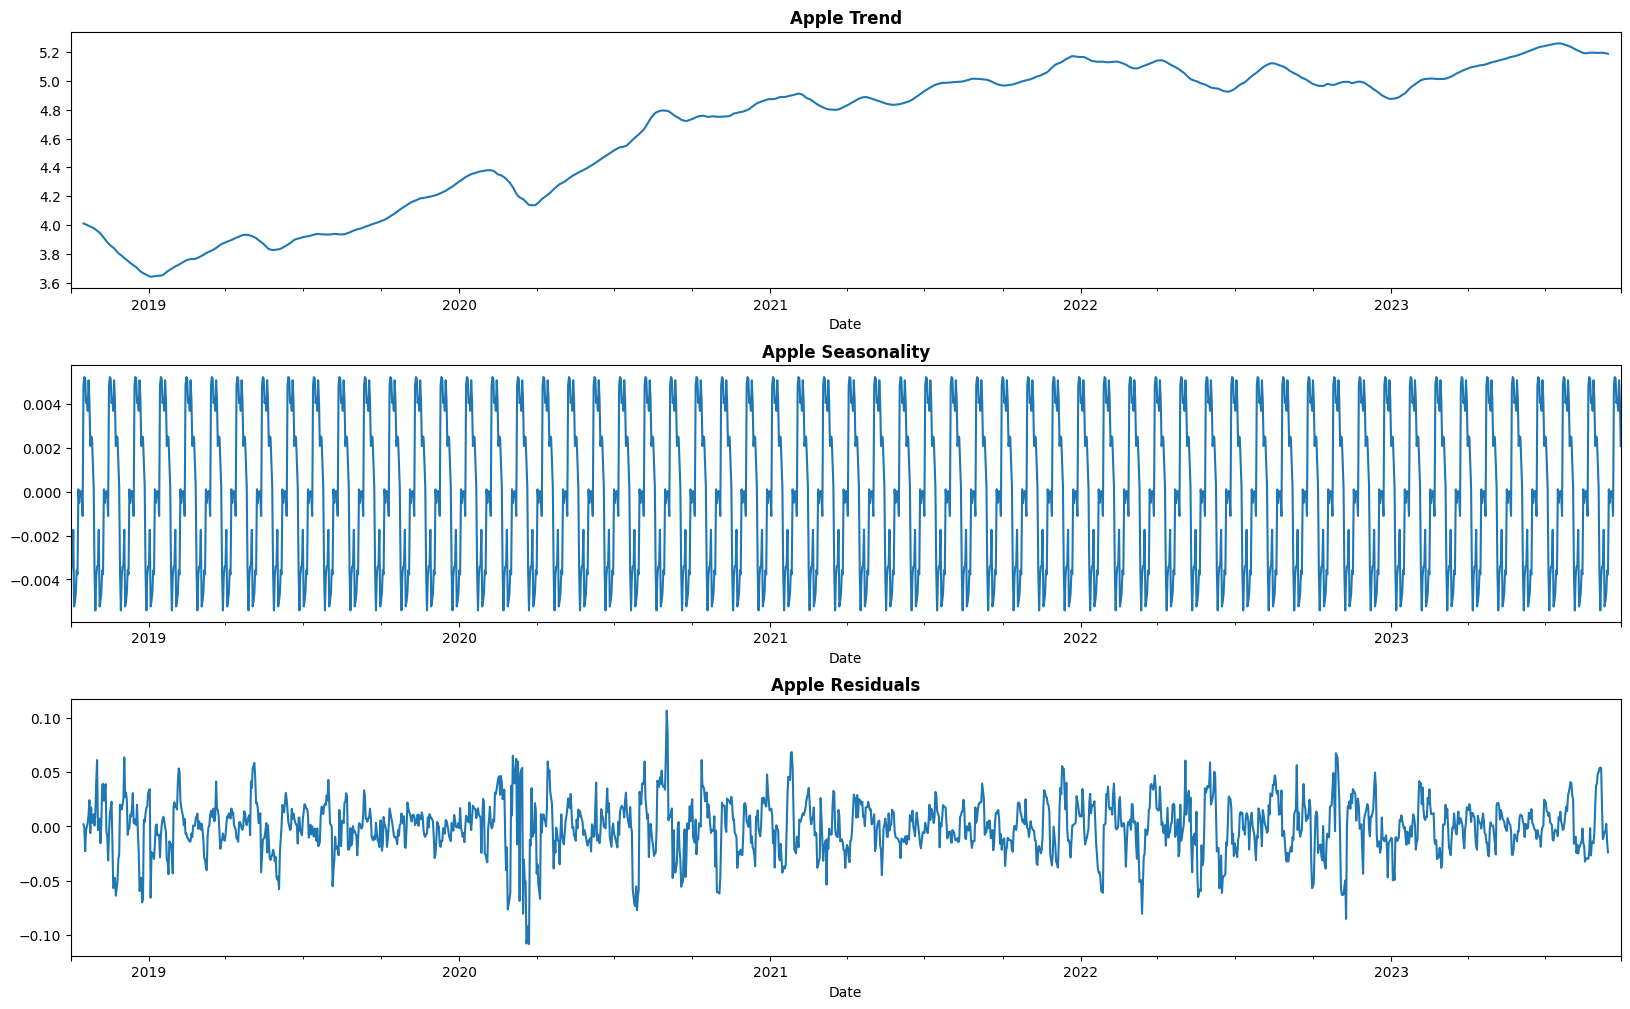

In [16]:
apple_ts = stocks_df["Apple"]
apple_log = calculate_log_price(apple_ts)

plot_seasonal_decomposition(apple_log, decomp_model="additive", decomp_period=30)

We then proceed to test the logged Apple time series for stationarity. This step involves evaluating:
- __How many differences are required__: We assess the number of non-seasonal differences needed to achieve stationarity. This helps determine if a single difference is enough or if additional differencing is necessary to stabilise the mean and variance.
- __Whether differencing seasonally once or twice works__: We examine the effects of applying seasonal differencing once or twice. This allows us to identify the optimal seasonal differencing order that removes any periodic patterns while maintaining the integrity of the data.
- __Whether applying a normal difference with seasonal differencing results in a stationary time series__: We test if combining normal differencing with seasonal differencing effectively transforms the time series into a stationary one. This approach ensures that both non-seasonal and seasonal trends are addressed, making the data suitable for further analysis and modelling.

Here, we can see that `d = 1` and `D = 1` works well for our SARIMA model later on.

In [17]:
# Original logged time series
adf_test(apple_log, name="Apple Logged Stock Price Time Series")

# 1st differenced time series
adf_test(apple_log, k_diff=1, name="Apple 1st Differenced Time Series")

# 1st seasonally differenced time series
adf_test(
    apple_log,
    k_seasonal_diff=1,
    seasonal_periods=30,
    name="Apple 1st Seasonally Differenced Time Series",
)

# 1st differenced and 1st seasonally differenced time series
adf_test(
    apple_log,
    k_diff=1,
    k_seasonal_diff=1,
    seasonal_periods=30,
    name="Apple 1st Differenced & 1st Seasonally Differenced Time Series",
)

2025-02-11 21:02:27.855 | DEBUG    | __main__:adf_test:17 - Performing ADF Test for Apple Logged Stock Price Time Series
2025-02-11 21:02:27.935 | INFO     | __main__:adf_test:29 - 
    ADF Statistic: -1.03671
    p-value: 0.73964
2025-02-11 21:02:27.937 | WARNING  | __main__:adf_test:36 - Time series is not stationary!

2025-02-11 21:02:27.938 | DEBUG    | __main__:adf_test:17 - Performing ADF Test for Apple 1st Differenced Time Series
2025-02-11 21:02:27.993 | INFO     | __main__:adf_test:29 - 
    ADF Statistic: -8.60073
    p-value: 0.00000
2025-02-11 21:02:27.994 | SUCCESS  | __main__:adf_test:34 - Time series is stationary

2025-02-11 21:02:27.995 | DEBUG    | __main__:adf_test:17 - Performing ADF Test for Apple 1st Seasonally Differenced Time Series
2025-02-11 21:02:28.052 | INFO     | __main__:adf_test:29 - 
    ADF Statistic: -7.68419
    p-value: 0.00000
2025-02-11 21:02:28.053 | SUCCESS  | __main__:adf_test:34 - Time series is stationary

2025-02-11 21:02:28.054 | DEBUG    |

After testing for stationarity, we examine the first-differenced and first-seasonally differenced datasets for correlations between the time series and specific lags, using a `seasonal_period = 30`. Spikes in the ACF and PACF plots will guide us in determining the appropriate values for $p$ and $q$.

Based on the plots, we observe spikes at `p = 1`, `q = 1`, and at intervals of 30 (a single spike in the ACF and a tapering off at every 30th interval in the PACF), suggesting `P = 2` and `Q = 1`. We will proceed with these values for further analysis.

2025-02-11 21:02:28.159 | DEBUG    | __main__:plot_acf_pacf:10 - Plotting ACF and PACF plots for Apple Log Returns


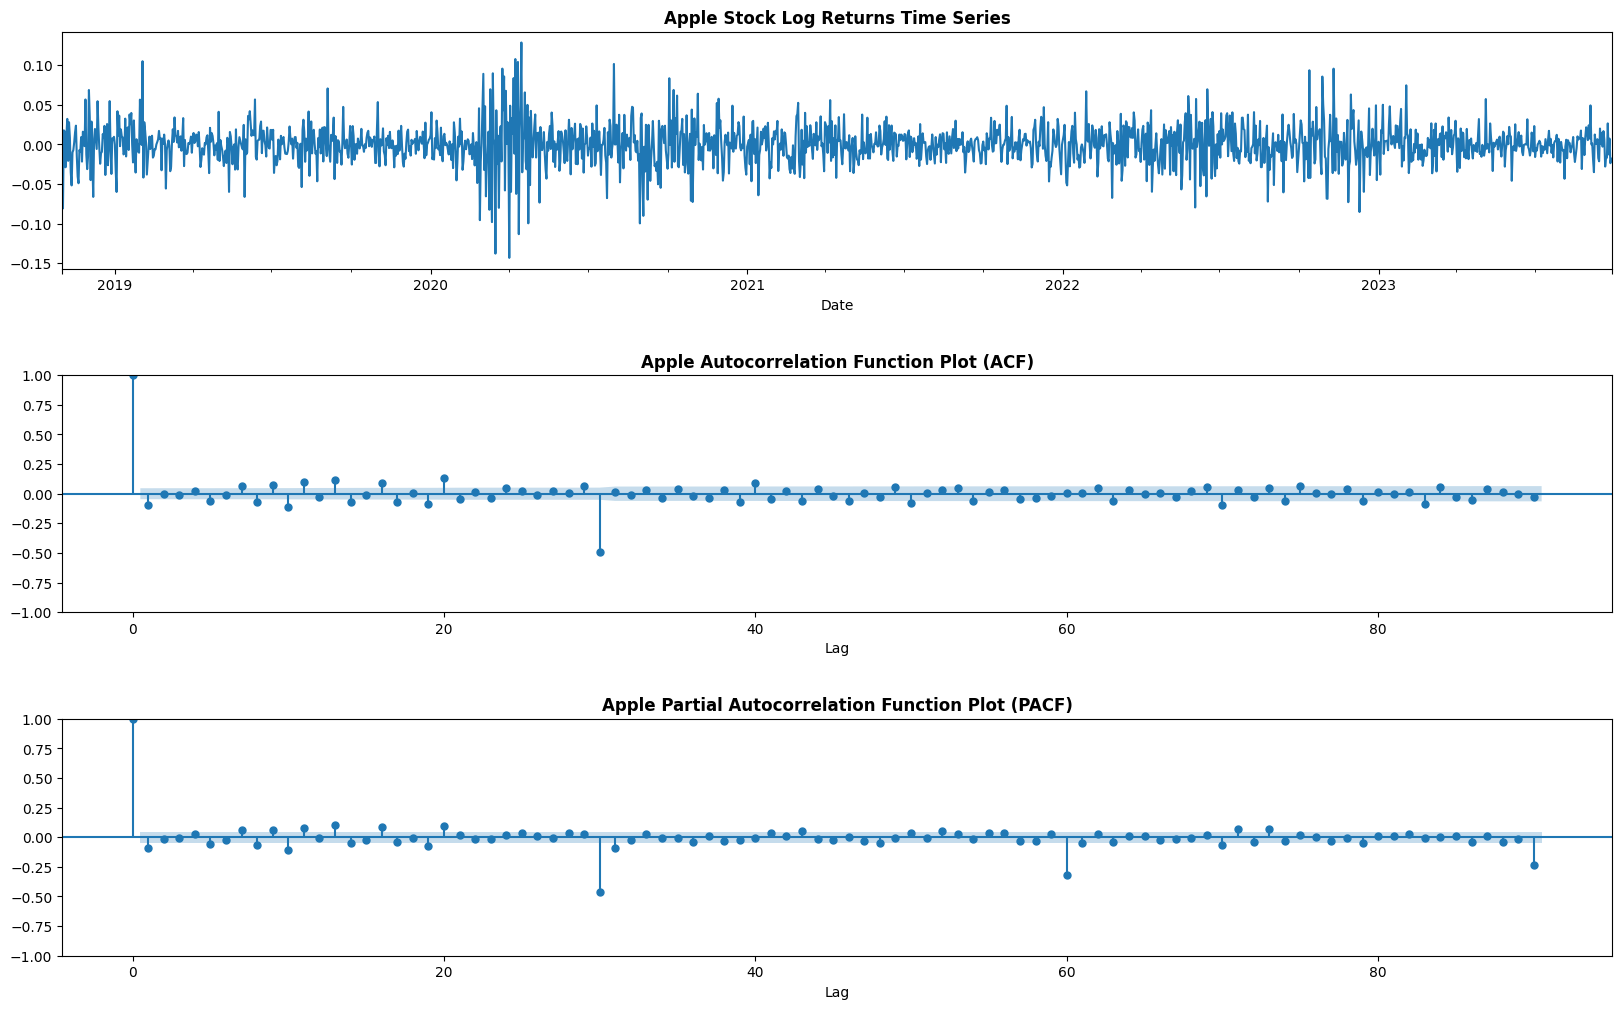

In [18]:
plot_acf_pacf(
    diff(apple_log, k_diff=1, k_seasonal_diff=1, seasonal_periods=30),
    acf_lags=90,
    pacf_lags=90,
)

We perform an 80-20 split on the logged Apple time series and train both a Holt-Winters model with `seasonal_periods = 30`, and a SARIMA model with `order = (1, 1, 1)` and `seasonal_order = (2, 1, 1, 30)`, based on our previous analysis of the time series.

The results show that, in general, our predictions for the test period follow the upward trend. The HWES model yields a MAPE of 7%, while the SARIMA model achieves a MAPE of 6.7%, indicating that SARIMA performs slightly better in capturing more accurate predictions.

2025-02-11 21:02:28.490 | DEBUG    | __main__:train_eval_hwes_model:11 - Training and evaluating HWES model for Apple
2025-02-11 21:02:28.668 | INFO     | __main__:train_eval_hwes_model:32 - Holt-Winters Exponential Smoothing Forecast Mean Absolute Percentage Error (MAPE): 7.00%


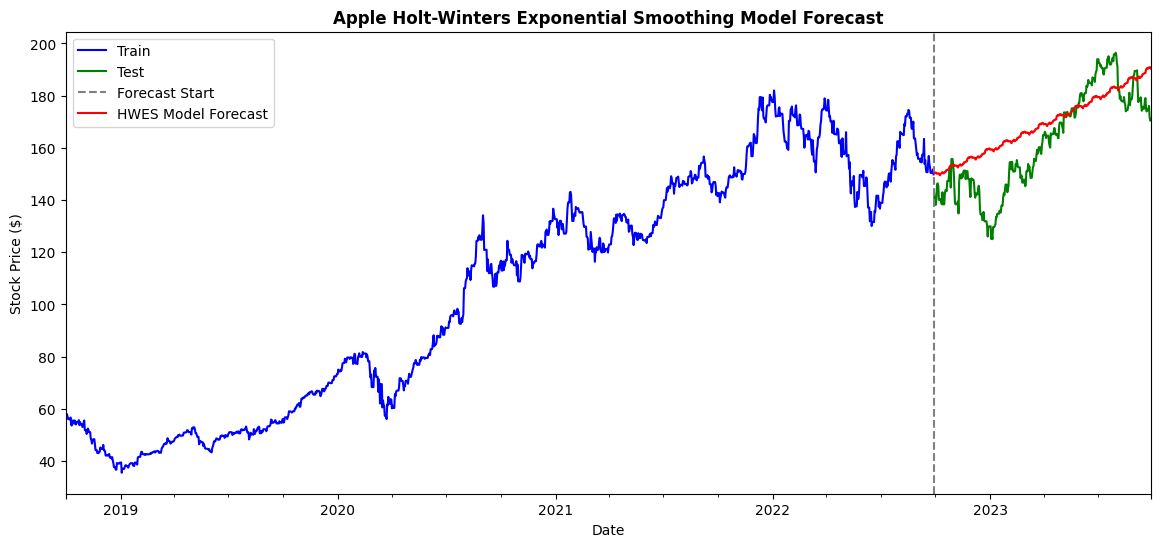

2025-02-11 21:02:28.782 | DEBUG    | __main__:train_eval_arima_model:15 - Training and evaluating SARIMA model for Apple


In [ ]:
train, test = train_test_split(apple_log)
train_eval_hwes_model(train, test, seasonal_periods=30)
train_eval_arima_model(train, test, order=(1, 1, 1), seasonal_order=(2, 1, 1, 30))

Using the models developed earlier, we proceed to forecast the Apple stock price for the next 60 days.

In [ ]:
pred_hwes_model(apple_log, seasonal_periods=30)
pred_arima_model(apple_log, order=(1, 1, 1), seasonal_order=(2, 1, 1, 30))

## Amazon Analysis <a id='4'></a>

We carry out the same analysis as before to identify the optimal seasonality period, ensuring that we capture the seasonal trend while maintaining computational efficiency. For Amazon, `decomp_period = 20` appears adequate based on our seasonal decomposition plot.

In [ ]:
amazon_ts = stocks_df["Amazon"]
amazon_log = calculate_log_price(amazon_ts)

plot_seasonal_decomposition(amazon_log, decomp_model="additive", decomp_period=20)

From the ADF tests for the logged Amazon time series, `d = 1` and `D = 1` works well for our SARIMA.

In [ ]:
# Original logged time series
adf_test(amazon_log, name="Amazon Logged Stock Price Time Series")

# 1st differenced time series
adf_test(amazon_log, k_diff=1, name="Amazon 1st Differenced Time Series")

# 1st seasonally differenced time series
adf_test(
    amazon_log,
    k_seasonal_diff=1,
    seasonal_periods=20,
    name="Amazon 1st Seasonally Differenced Time Series",
)

# 1st differenced and 1st seasonally differenced time series
adf_test(
    amazon_log,
    k_diff=1,
    k_seasonal_diff=1,
    seasonal_periods=20,
    name="Amazon 1st Differenced & 1st Seasonally Differenced Time Series",
)

From the plots, we observe spikes at `p = 1`, `q = 1`, and at intervals of 20 (with a single spike in the ACF and a gradual tapering off at every 20th interval in the PACF). This indicates that `P = 2` and `Q = 1`. We will use these values for the subsequent analysis.

In [ ]:
plot_acf_pacf(
    diff(amazon_log, k_diff=1, k_seasonal_diff=1, seasonal_periods=20),
    acf_lags=60,
    pacf_lags=60,
)

We perform an 80-20 split on the logged Amazon time series and train both a Holt-Winters model with `seasonal_periods = 20`, and an SARIMA model with `order = (1, 1, 1)` and `seasonal_order = (2, 1, 1, 20)`, based on our previous analysis of the time series.

The HWES model generally captures the upward trend in the stock price, yielding an MAPE of 16.2%, while the SARIMA model better captures the downward trend, with an MAPE of 16.02%. This suggests some variation in how each model processes the data and interprets the trend. However, for comparison, the SARIMA model performs slightly better, as indicated by the lower MAPE.

In [ ]:
train, test = train_test_split(amazon_log)
train_eval_hwes_model(train, test, seasonal_periods=20)
train_eval_arima_model(train, test, order=(1, 1, 1), seasonal_order=(2, 1, 1, 20))

Using the models developed earlier, we proceed to forecast the Amazon stock price for the next 60 days.

In [ ]:
pred_hwes_model(amazon_log, seasonal_periods=20)
pred_arima_model(amazon_log, order=(1, 1, 1), seasonal_order=(2, 1, 1, 30))

## DBS Analysis <a id='5'></a>

Lastly, we analyse the time series for DBS stock prices and determine that a `decomp_period = 25` is adequate for capturing the seasonality in the data.

In [ ]:
dbs_ts = stocks_df["DBS"]
dbs_log = calculate_log_price(dbs_ts)

plot_seasonal_decomposition(dbs_log, decomp_model="additive", decomp_period=25)

`d = 1` and `D = 1` works well for the SARIMA model when applied to DBS’s logged stock prices.

In [ ]:
# Original logged time series
adf_test(dbs_log, name="DBS Logged Stock Price Time Series")

# 1st differenced time series
adf_test(dbs_log, k_diff=1, name="DBS 1st Differenced Time Series")

# 1st seasonally differenced time series
adf_test(
    dbs_log,
    k_seasonal_diff=1,
    seasonal_periods=25,
    name="DBS 1st Seasonally Differenced Time Series",
)

# 1st differenced and 1st seasonally differenced time series
adf_test(
    dbs_log,
    k_diff=1,
    k_seasonal_diff=1,
    seasonal_periods=25,
    name="DBS 1st Differenced & 1st Seasonally Differenced Time Series",
)

From the plots, we observe spikes at `p = 2`, `q = 2`, and at intervals of 25 (with a single spike in the ACF and a gradual tapering off at every 25th interval in the PACF). This indicates that `P = 2` and `Q = 1`. We will use these values for the subsequent analysis.

In [ ]:
plot_acf_pacf(
    diff(dbs_log, k_diff=1, k_seasonal_diff=1, seasonal_periods=25),
    acf_lags=50,
    pacf_lags=50,
)

We perform an 80-20 split on the logged DBS time series and train both a Holt-Winters model with `seasonal_periods = 25`, and an SARIMA model with `order = (2, 1, 2)` and `seasonal_order = (1, 1, 1, 25)`, based on our previous analysis of the time series. Although the PACF plot suggests using `P = 2`, our ARIMA model with `P = 1` resulted in a lower AICc and MAPE, hence we proceeded with this set of hyperparameters.

The results show that, overall, our predictions for the test period align with the upward trend. The HWES model produces a MAPE of 4.86%, while the SARIMA model yields a MAPE of 5.42%, suggesting that the HWES model performs better in capturing more accurate predictions for DBS.

In [ ]:
train, test = train_test_split(dbs_log)
train_eval_hwes_model(train, test, seasonal_periods=25)
train_eval_arima_model(
    train, test, order=(2, 1, 2), seasonal_order=(1, 1, 1, 25)
)  # P=1 yields lowest AIC and best MAPE, ceteris paribus

Using the models developed earlier, we proceed to forecast the DBS stock price for the next 60 days.

In [ ]:
pred_hwes_model(dbs_log, seasonal_periods=25)
pred_arima_model(dbs_log, order=(2, 1, 2), seasonal_order=(1, 1, 1, 25))

# 6. Conclusion <a id = '6'></a> 

Based on our analysis of the Apple, Amazon, and DBS stock price time series, we found that the data is generally non-stationary and required differencing (both non-seasonally and seasonally) to achieve stationarity. Seasonal decomposition and diagnostic plotting of the ACF and PACF plots were crucial for determining the correct seasonal periods and model orders for both HWES and SARIMA models.

Despite the modelling efforts, there is no clear winner between the models, as HWES and SARIMA sometimes outperform each other and even capture different trends, especially during periods of high volatility. Nonetheless, identifying the correct hyperparameters through data analysis is essential for improving model performance.

Future work could focus on fine-tuning the models by optimising the model hyperparameters and validating the models used in this analysis. This can be achieved by examining QQ plots, standardised residuals, and correlograms to ensure that model assumptions are met.